Executive Summary :

DECam image comparison : illustrate catastrophic mismatches between  decaps single-epoch catalog,  and LSST stack src catalog based on InstCal DECam images.

In [2]:
import numpy as np

# Necessary imports ..

import matplotlib.pyplot as plt
from astropy.table import Table
import os
import numpy as np
from astropy.io import fits
from astropy.stats import sigma_clipped_stats
from astropy.visualization import SqrtStretch
from astropy.visualization.mpl_normalize import ImageNormalize
import urllib.request

from astropy.coordinates import SkyCoord
from astropy import units as u

from itertools import product
from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy.table import hstack
from astropy.table import vstack
from scipy.stats import binned_statistic as bs



In [3]:
image_database = '../data_products/decaps_catalogs/imdb.fits'
imdb_hdu = fits.open(image_database)
imdb = Table(imdb_hdu[1].data)

In [4]:
#mask_recno = imdb['sb_recno'] == 611980
#m = imdb_short['sb_name'] == 'c4d_170122_053255_ooi_g_v1.fits

# this can be used to find the name of single-band catalog for 
# the given visit to make it more automatic ...
visit = 611980
cat_name = imdb[imdb['expnum'] == visit]['catfname'].data[0]

print('The single-band catalog name corresponding to visit %d is %s' %(visit, cat_name))

# the cat name is based on the image name ... 
#image_name = 'c4d_170122_055542_ooi_g'
#cat_name = image_name + '_v1.cat.fits'
singleDir = '../data_products/decaps_catalogs/single_epoch/'
file_name  = singleDir + cat_name

# check if the catalog already exists
if cat_name not in  os.listdir(singleDir) : 
    print('Downloading the catalog...')# if not, download it ...
    url = 'https://faun.rc.fas.harvard.edu/decaps/release/cat/' + cat_name
    urllib.request.urlretrieve(url, file_name)

The single-band catalog name corresponding to visit 611980 is c4d_170122_055542_ooi_g_v1.cat.fits


In [5]:
decaps_hdu = fits.open(file_name)
#http://www.astropy.org/astropy-tutorials/FITS-tables.html
# hdu.info() would display all available tables - 
# there is a single catalog per CCD, 
# called 'S21_CAT', etc, based on CCD name. 

# save the zero point for this catalog 
decaps_zeropoint = decaps_hdu[0].header['MAGZERO']  
# one per entire image composed of multiple CCDs
print('The decaps single-epoch catalog zeropoint is %f'%decaps_zeropoint)

The decaps single-epoch catalog zeropoint is 29.047000


In [7]:
# Read the LSST zeropoint - it's the same 
# for all ccd's across the mosaic ... 
outDir = '../data_products/LSST_Stack/DECam/'+str(visit)+'/'

# first check calexp for zero point magnitude
# it is exactly the same for all CCDs in a mosaic 
calexp_files = os.listdir(outDir+'calexp/')
calexp_hdu = fits.open(outDir+'calexp/' + calexp_files[1])
lsst_zeropoint = calexp_hdu[0].header['MAGZERO']
print('The lsst measured zeropoint for decam is %f'%lsst_zeropoint)




The lsst measured zeropoint for decam is 29.047000


In [8]:
# Make only once : the translation of ccdnum to ccdname,  to position in the 
# decals hdu 

ccd_name_dict = {}
catalog_decaps_pos = {}

# Make sure that all cards got downloaded - 
# the single-epoch catalog is a FITS file 
# where each card corresponds to a CCD 
assert len(decaps_hdu[:]) == 181  

for i in range(1,180) : 
    if 'IMAGE' in decaps_hdu[i].header['XTENSION'] :
        ccdnum = decaps_hdu[i].header['CCDNUM']
        detpos = decaps_hdu[i].header['DETPOS']
        ccd_name_dict[ccdnum] = detpos
        catalog_decaps_pos[ccdnum] = int(i+2)
        
# The coveted dictionary of ccdnum  vs ccdname ! 
print(np.ravel(ccd_name_dict))

# and the translation of ccdnum  to hduposition of the catalog .... 
print(np.ravel(catalog_decaps_pos))

#sss

[ {1: 'S29', 3: 'S31', 4: 'S25', 5: 'S26', 6: 'S27', 7: 'S28', 8: 'S20', 9: 'S21', 10: 'S22', 11: 'S23', 12: 'S24', 13: 'S14', 14: 'S15', 15: 'S16', 16: 'S17', 17: 'S18', 18: 'S19', 19: 'S8', 20: 'S9', 21: 'S10', 22: 'S11', 23: 'S12', 24: 'S13', 25: 'S1', 26: 'S2', 27: 'S3', 28: 'S4', 29: 'S5', 30: 'S6', 31: 'S7', 32: 'N1', 33: 'N2', 34: 'N3', 35: 'N4', 36: 'N5', 37: 'N6', 38: 'N7', 39: 'N8', 40: 'N9', 41: 'N10', 42: 'N11', 43: 'N12', 44: 'N13', 45: 'N14', 46: 'N15', 47: 'N16', 48: 'N17', 49: 'N18', 50: 'N19', 51: 'N20', 52: 'N21', 53: 'N22', 54: 'N23', 55: 'N24', 56: 'N25', 57: 'N26', 58: 'N27', 59: 'N28', 60: 'N29', 62: 'N31'}]
[ {1: 3, 3: 6, 4: 9, 5: 12, 6: 15, 7: 18, 8: 21, 9: 24, 10: 27, 11: 30, 12: 33, 13: 36, 14: 39, 15: 42, 16: 45, 17: 48, 18: 51, 19: 54, 20: 57, 21: 60, 22: 63, 23: 66, 24: 69, 25: 72, 26: 75, 27: 78, 28: 81, 29: 84, 30: 87, 31: 90, 32: 93, 33: 96, 34: 99, 35: 102, 36: 105, 37: 108, 38: 111, 39: 114, 40: 117, 41: 120, 42: 123, 43: 126, 44: 129, 45: 132, 46: 135

In [9]:
# Combine all lsst sources from all ccd's , 
# and all decals sources from all ccd's, to improve statistics ... 

#def process_src_ccd(outDir, visit, i):


# Initialize storage AstroPy tables :
arr = {'lsst_mag':[], 'coord_ra':[],'coord_dec':[]}
ccd_lsst_stack = Table(arr, names=('lsst_mag', 'coord_ra', 'coord_dec'), 
                 dtype=('f8', 'f8', 'f8'))  

arr = {'decaps_mag':[],'ra':[],'dec':[]}
ccd_decaps_stack = Table(arr, names = ('decaps_mag', 'ra', 'dec'),
                        dtype = ('f8', 'f8', 'f8'))

# loop over all ccds adding to stacks...
#
src_files = os.listdir(outDir+'src/')
start = len('src-0'+str(visit)+'_')
stop = len('.fits')

for i in range(len(src_files)):
    ccdnum  = src_files[i][start:-stop]  # string
    ccd_number = float(ccdnum)
    fname = 'src-0'+str(visit)+'_'+ccdnum+'.fits'
    hdu = fits.open(outDir +'src/'+ fname)
    print(fname)
    
    # convert to an AstroPy table 
    ccd_data = Table(hdu[1].data)

    # only consider positive fluxes... 
    mask_neg_fluxes = ccd_data['base_PsfFlux_flux'].data > 0
    # just select rows that don't have negative fluxes...
    ccd_data_good = ccd_data[mask_neg_fluxes]
    ccd_data_good['lsst_mag'] = -2.5* np.log10(ccd_data_good['base_PsfFlux_flux'])   +\
       lsst_zeropoint

    # keep only most relevant info... 
    ccd_lsst  =    ccd_data_good[['lsst_mag', 'coord_ra', 'coord_dec']] 

    # add to the stack
    ccd_lsst_stack    = vstack([ccd_lsst_stack ,ccd_lsst] )

    # Display mapping information
    print('  * ccd number %d ' % ccd_number)
    print('  * ccd name is %s'% ccd_name_dict[ccd_number])
    print('  * position in  decaps hdu  is %d'%catalog_decaps_pos[ccd_number])

    # read in decaps single-epoch catalog for that ccd... 
    ccd_decaps_cat =  Table(decaps_hdu[catalog_decaps_pos[ccd_number]].data) 

    # convert the fluxes to magnitudes 
    ccd_decaps_cat['decaps_mag'] = -2.5 * np.log10(ccd_decaps_cat['flux'].data) +\
    decaps_zeropoint

    # keep only the relevant info
    ccd_decaps = ccd_decaps_cat[['decaps_mag','ra','dec']]
    ccd_decaps_stack = vstack([ccd_decaps_stack, ccd_decaps])

print('Done')





src-0611980_23.fits
  * ccd number 23 
  * ccd name is S12
  * position in  decaps hdu  is 66
src-0611980_35.fits


/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel/__main__.py:53: RuntimeWarning: invalid value encountered in log10


  * ccd number 35 
  * ccd name is N4
  * position in  decaps hdu  is 102
src-0611980_62.fits
  * ccd number 62 
  * ccd name is N31
  * position in  decaps hdu  is 180
src-0611980_19.fits
  * ccd number 19 
  * ccd name is S8
  * position in  decaps hdu  is 54
src-0611980_58.fits
  * ccd number 58 
  * ccd name is N27
  * position in  decaps hdu  is 171
src-0611980_39.fits
  * ccd number 39 
  * ccd name is N8
  * position in  decaps hdu  is 114
src-0611980_15.fits
  * ccd number 15 
  * ccd name is S16
  * position in  decaps hdu  is 42
src-0611980_42.fits
  * ccd number 42 
  * ccd name is N11
  * position in  decaps hdu  is 123
src-0611980_54.fits
  * ccd number 54 
  * ccd name is N23
  * position in  decaps hdu  is 159
src-0611980_03.fits
  * ccd number 3 
  * ccd name is S31
  * position in  decaps hdu  is 6
src-0611980_55.fits
  * ccd number 55 
  * ccd name is N24
  * position in  decaps hdu  is 162
src-0611980_43.fits
  * ccd number 43 
  * ccd name is N12
  * position in  de

In [10]:
# Match sources from  decaps to lsst  per ccd 
# decam coordinates
decam_coord = SkyCoord(ra  = ccd_decaps_stack['ra']*u.degree, 
                       dec = ccd_decaps_stack['dec']*u.degree)  

# lsst coordinates : in radians ! 
lsst_coord = SkyCoord(ra = ccd_lsst_stack['coord_ra']*u.radian, 
                      dec= ccd_lsst_stack['coord_dec']*u.radian)  


# indices are into lsst ccd catalog 
# match decaps into lsst ... 
idx, d2d, d3d = decam_coord.match_to_catalog_sky(lsst_coord)  

# stack the two catalogs 
decam_to_lsst = hstack([ccd_decaps_stack ,ccd_lsst_stack[idx]],
               table_names=['decam','lsst']  )

print('There are %d decaps sources  and %d lsst sources.'%(len(decam_coord),
                                                      len(lsst_coord))
     )

# matches within 0.5 arcsec...
cut_arcsec = 0.5 
mask_arcsec = d2d.arcsec < cut_arcsec

# matches within 0.5 mag from one another ... 
decam_to_lsst['dmag'] = decam_to_lsst['lsst_mag'] - decam_to_lsst['decaps_mag']
cut_mag = 0.5
mask_mag = abs(decam_to_lsst['dmag'].data) < cut_mag
mask_comb  = mask_arcsec * mask_mag


print(' %d decaps srcs have an lsst match within %.1f arcsec'%(
    np.sum(mask_arcsec), cut_arcsec)
     )
print(' %d decaps srcs have an lsst match within %.1f mag'%(
    np.sum(mask_mag), cut_mag)
     )
print(' %d decaps srcs have an lsst match fulfilling both criteria'%np.sum(mask_comb)
     )

# Using the original table, make a column to flag which 
# decaps srcs have a good lsst match 

# Initialize with zeros
decam_to_lsst['lsst_match'] = 0

# Set to 1 only where the match is good, i.e. fulfills the combined selection masks
decam_to_lsst['lsst_match'][mask_comb] = 1 



There are 322654 decaps sources  and 275098 lsst sources.
 205677 decaps srcs have an lsst match within 0.5 arcsec
 220400 decaps srcs have an lsst match within 0.5 mag
 203225 decaps srcs have an lsst match fulfilling both criteria


/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel/__main__.py:30: RuntimeWarning: invalid value encountered in less


In [12]:
ccdnum

'36'

In [13]:
# Read in the LSST Stack processed version
# take just one CCD  ( eg. ccd10)
ccdnum = 10
fname = 'calexp-0'+str(visit)+'_'+str(ccdnum)+'.fits'
print(fname)
hdu = fits.open(outDir + 'calexp/'+fname)
g_zeropoint = hdu[0].header['MAGZERO']
lsst_image_data = hdu[1].data


calexp-0611980_10.fits


In [14]:
# Also read the original DECam image
# it contains all ccds

from photutils import CircularAperture
image_name = imdb[imdb['expnum'] == visit]['pldsid'][0]+'.fits.fz'
print('Seeking image %s'%image_name)

image_dir = '../raw_data/DECam/'
if image_name not in os.listdir(image_dir):
    print('Need to download %s'%image_name)

image_hdu = fits.open(image_dir +image_name)

# position of any ccd in the image_hdu 
# is the ccdnum-1 : 
assert image_hdu[ccdnum-1].header['CCDNUM'] == ccdnum

# need to choose only one to display... 
#decam_image_data = image_hdu[ccdnum-1].data


Seeking image c4d_170122_055542_ooi_g_v1.fits.fz


In [15]:
# Translate ra,dec to pixel x,y, coordinates .. 
#

x_px_scale = image_hdu[0].header['PIXSCAL1']  # arcsec / pixel
y_px_scale = image_hdu[0].header['PIXSCAL2']
print(x_px_scale)
print(y_px_scale)

from astropy import wcs

def add_ccd_xycoords(table, image_hdu, ccdnum=10):

    # Parse the WCS keywords in the primary HDU
    w = wcs.WCS(image_hdu[ccdnum-1].header)

    # Example:  pixel to world
    #pixcrd = np.array([[0, 0], [24, 38], [45, 98]], np.float_)
    #world  = w.wcs_pix2world(pixcrd, 1)

    # Example : world to pixel
    #pixcrd2 = w.wcs_world2pix(world, 1)

    # Check that it works ...
    #assert np.max(np.abs(pixcrd - pixcrd2)) < 1e-6

    # first need to express the ra,dec in terms of pixel location on the image ...
    radec_decaps = np.column_stack((table['ra'], 
                                    table['dec'])
                                  )
    radec_lsst = np.column_stack((360*table['coord_ra'] / (2*np.pi), 
                                  360*table['coord_dec']/(2*np.pi))
                                )
    
    # DECAPS coords:  ra, dec  ,  LSST coords: coord_ra , coord_dec 
    pixcrd_decaps = w.wcs_world2pix(radec_decaps,1)
    pixcrd_lsst = w.wcs_world2pix(radec_lsst,1)
    
    # plot histogram to show 
    # that since these are sources from the
    # entire catalog, their x,y position on the chip would be 
    # beyond the chip limits,
    # which are (0,2048) in x, 
    # and (0,4096) in y 

    #plt.hist(pixcrd_decaps)

    # make columns for decaps  ra,dec based x,y coords 
    xcords = np.ravel(np.hsplit(pixcrd_decaps,2)[0])
    ycords = np.ravel(np.hsplit(pixcrd_decaps,2)[1])
    colname_x = 'ccd'+str(ccdnum)+'_x_decaps'
    colname_y = 'ccd'+str(ccdnum)+'_y_decaps'
    table[colname_x] = xcords 
    table[colname_y] = ycords
    print('We added two columns translating decaps ra,dec to x,y coords on ccd %d'%ccdnum)
    print('They are called: \n %s, and %s'%(colname_x, colname_y))
    
    
    # make columns for lsst  ra,dec based x,y coords
    xcords = np.ravel(np.hsplit(pixcrd_lsst,2)[0])
    ycords = np.ravel(np.hsplit(pixcrd_lsst,2)[1])
    colname_x = 'ccd'+str(ccdnum)+'_x_lsst'
    colname_y = 'ccd'+str(ccdnum)+'_y_lsst'
    table[colname_x] = xcords 
    table[colname_y] = ycords
    
    print('We added two columns translating lsst ra,dec to x,y coords on ccd %d'%ccdnum)
    print('They are called: \n %s, and %s'%(colname_x, colname_y))
    
    
    return table 
    
decam_to_lsst = add_ccd_xycoords(decam_to_lsst, image_hdu)
#lsst_to_decam = add_ccd_xycoords(lsst_to_decam, image_hdu)
 



0.27
0.27
We added two columns translating decaps ra,dec to x,y coords on ccd 10
They are called: 
 ccd10_x_decaps, and ccd10_y_decaps
We added two columns translating lsst ra,dec to x,y coords on ccd 10
They are called: 
 ccd10_x_lsst, and ccd10_y_lsst


Total sources within this cutout :  29
Using calexp-0611980_10.fits
Sources with no lsst match, with decaps mag < 13 : 1
  decaps_mag     lsst_mag  
------------- -------------
11.9704704285 12.5410783705


/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/astropy/visualization/stretch.py:115: RuntimeWarning: invalid value encountered in sqrt
  np.sqrt(values, out=values)
/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/matplotlib/colors.py:494: RuntimeWarning: invalid value encountered in less
  cbook._putmask(xa, xa < 0.0, -1)


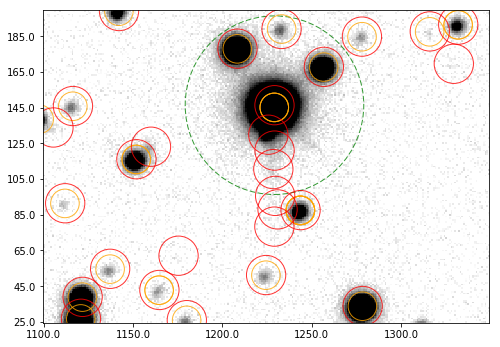

In [96]:
%matplotlib inline
from matplotlib.patches import Circle

# Plot the very bright mismatches .... 

# grab the size of the image in pixels 
# from the image header .... 
xaxis_length = image_hdu[ccdnum-1].header['NAXIS1']
yaxis_length = image_hdu[ccdnum-1].header['NAXIS2']

xcords = decam_to_lsst['ccd10_x_decaps']
ycords = decam_to_lsst['ccd10_y_decaps']

# select a subregion within a chosen part of the image ....
xmin,xmax = 1100,1350 # xaxis_length 
ymin,ymax = 25,200 # yaxis_length 

mx = (xmin < xcords) * (xcords < xmax)
my = (ymin < ycords) * (ycords < ymax)

print('Total sources within this cutout :  %d'%np.sum(mx*my))

# select a subset of the original table within
# this cutout ... ( based on decaps sources in that cutout)
cutout_table = decam_to_lsst[mx*my]

# First select the bright mismatches : only in decam 
# but not in LSST .... 
# (at least not within 0.5 arcsec and 0.5 mag ... )

#xmin,xmax = min(decam_to_lsst[m]['ccd10_x_decaps']), \
#max(decam_to_lsst[m]['ccd10_x_decaps'])
#ymin,ymax = min(decam_to_lsst[m]['ccd10_y_decaps']), \
#max(decam_to_lsst[m]['ccd10_y_decaps'])
# plot the  decam- lsst mismatches .... 
fig,ax = plt.subplots(1,1, figsize=(8,16))

# print the image ....
ccdnum = 10
fname = 'calexp-0'+str(visit)+'_'+str(ccdnum)+'.fits'
print('Using %s'%fname)
hdu = fits.open(outDir + 'calexp/'+fname)
lsst_image_data = hdu[1].data
mean, median, std = sigma_clipped_stats(lsst_image_data[ymin:ymax,xmin:xmax],
                                        sigma=3.0, iters=5) 
norm = ImageNormalize(stretch=SqrtStretch())
ax.imshow(lsst_image_data[ymin:ymax,xmin:xmax], 
         cmap='Greys', origin='lower', norm=norm,
         vmax = 200, vmin = 5)

# translate x ticks 
new_labels = [str(item +xmin) for item in ax.get_xticks()]
ax.set_xticklabels(new_labels)

# translate y ticks 
new_labels = [str(item +ymin) for item in ax.get_yticks()]
ax.set_yticklabels(new_labels)
    
    
# plot apertures for bright decaps sources, that 
# did not have an lsst match within 0.5 arcsec and 0.5 mag
m1 = cutout_table['lsst_match'] == 0
m2 = np.bitwise_not(np.isnan(cutout_table['decaps_mag']))
m3 = cutout_table['decaps_mag'] < 16
m = m1*m2*m3
print('Sources with no lsst match, with decaps mag < 13 : %d'%np.sum(m))
print(cutout_table[m][['decaps_mag', 'lsst_mag']])
for xx,yy in zip(cutout_table['ccd10_x_decaps'][m]-xmin,
                 cutout_table['ccd10_y_decaps'][m]-ymin):
    circ = Circle((xx,yy),50, alpha=0.8, fill=False,ls='--',ec='green')
    ax.add_patch(circ)

# Here we just plot all LSST detections in that region ...     
xcords = cutout_table['ccd10_x_lsst']
ycords = cutout_table['ccd10_y_lsst']
for xx,yy in zip(xcords-xmin,ycords-ymin):
    # https://matplotlib.org/devdocs/api/_as_gen/matplotlib.patches.Circle.html 
    circ = Circle((xx,yy), radius=8,alpha=0.8, fill=False, ec='orange')
    ax.add_patch(circ)
    
    
# Finally, also plot all DECaPS sources in that region 
xcords = cutout_table['ccd10_x_decaps']
ycords = cutout_table['ccd10_y_decaps']
for xx,yy in zip(xcords-xmin,ycords-ymin):
    # https://matplotlib.org/devdocs/api/_as_gen/matplotlib.patches.Circle.html 
    circ = Circle((xx,yy), radius=11, alpha=0.8, fill=False, ec='red')
    ax.add_patch(circ)
    
plt.savefig('../data_products/decaps_lsst_compare/'+str(visit)+\
            '_ccd-'+str(ccdnum)+'_faint_feat.png', bbox_inches='tight')

In [ ]:
An example where the LSST vs 

Investigate other bright mismatches - those above are an example of LSST reporting a smaller magnitude than decaps. How about even brighter sources ? 

/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel/__main__.py:2: RuntimeWarning: invalid value encountered in less
  from ipykernel import kernelapp as app
/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel/__main__.py:3: RuntimeWarning: invalid value encountered in greater
  app.launch_new_instance()


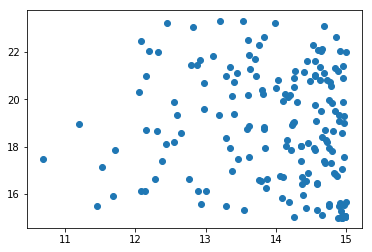

In [89]:
m1= decam_to_lsst['lsst_match'] == 0
m2= decam_to_lsst['decaps_mag'] < 15
m3 = decam_to_lsst['decaps_mag'] > 10
m4 = decam_to_lsst['lsst_mag'] > 15
# within ccd10 ...
xcords = decam_to_lsst['ccd10_x_decaps']
ycords = decam_to_lsst['ccd10_y_decaps']

# select a subregion within a chosen part of the image ....
xmin,xmax = 0,  xaxis_length 
ymin,ymax = 0, yaxis_length 

mx = (xmin < xcords) * (xcords < xmax)
my = (ymin < ycords) * (ycords < ymax)

m = m1*m2*m3*m4
plt.scatter(decam_to_lsst['decaps_mag'][m], decam_to_lsst['lsst_mag'][m])

I want to be able to quickly show a small selection of a ccd where this objects lie ... Essentially, a postage stamp of comparison between the decaps and lsst thing...

In [92]:
decam_to_lsst[m]

decaps_mag,ra,dec,lsst_mag,coord_ra,coord_dec,dmag,lsst_match,ccd10_x_decaps,ccd10_y_decaps,ccd10_x_lsst,ccd10_y_lsst,ccd44_x_decaps,ccd44_y_decaps,ccd44_x_lsst,ccd44_y_lsst,ccd41_x_decaps,ccd41_y_decaps,ccd41_x_lsst,ccd41_y_lsst,ccd27_x_decaps,ccd27_y_decaps,ccd27_x_lsst,ccd27_y_lsst
float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
12.1533069611,121.230260009,-23.7128405274,18.6908043627,2.11589358792,-0.413854839115,6.53749740168,0,4548.63942965,6377.62310688,4539.03578036,6396.59222364,-6694.40143241,-4234.89893337,-6704.06821423,-4216.05818305,-6701.20647124,8496.63832061,-6710.8032675,8515.55839139,-2200.33738026,10624.7171762,-2209.9135138,10643.6584705
13.3736801147,120.759739187,-24.0391536906,16.970274248,2.10766073367,-0.419617617955,3.59659413321,0,9002.13948451,494.966659916,9045.37737226,499.002756409,-2225.56102314,-10050.3987072,-2182.56855459,-10046.5733181,-2248.37865943,2624.0933612,-2205.1464197,2628.17854711,2248.54975165,4747.91170561,2291.74389417,4751.99717811
12.434753418,120.789944296,-24.0396133288,18.1160159511,2.10816423681,-0.419624223664,5.6812625331,0,9008.43952223,871.186149511,9050.56746837,858.314668652,-2221.60278113,-9681.30904706,-2179.60212669,-9694.05923366,-2242.07247842,3000.61099571,-2199.95383023,2987.7787141,2254.54729701,5124.41238317,2296.64445332,5111.58005639
14.9584922791,121.006410588,-24.0424268194,15.0198899497,2.11194930961,-0.419618136455,0.0613976706274,0,9048.43294384,3567.43687143,9047.35085453,3559.60850009,-2194.00352003,-7022.63858268,-2195.05689025,-7030.38826425,-2200.96930408,5698.55723889,-2202.05649324,5690.72291767,2293.3623513,7821.81801145,2292.28226026,7813.98711556
14.9509525299,121.009777017,-24.0418401618,15.0147034776,2.11200685004,-0.419607736698,0.0637509476905,0,9040.46166203,3609.40042175,9039.25276554,3600.70512934,-2202.08493716,-6981.08918735,-2203.262223,-6989.69799162,-2208.90424921,5740.52596829,-2210.11889379,5731.82408323,2285.39501013,7863.77250795,2284.18825777,7855.07449508
14.5627174377,121.026005627,-24.1885479519,21.6116190608,2.11233716443,-0.422161605442,7.04890162307,0,11045.7038073,3804.90523305,11039.314147,3829.79527275,-203.449084439,-6786.86982421,-209.868485786,-6762.18143185,-205.663590251,5940.41735401,-212.02932006,5965.31970641,4288.13433587,8062.83004445,4281.7543627,8087.71736855
12.6537437439,121.062224858,-24.9655276117,18.570069975,2.11296256199,-0.43569354742,5.9163262311,0,21714.151268,4182.71316362,21684.8174502,4202.93029538,10446.7116371,-6353.6091788,10417.3870211,-6333.72043541,10476.7169836,6390.16340867,10447.1993199,6410.10678152,14898.8931115,8454.24792273,14869.9393125,8474.52768125
14.9433326721,120.188931955,-23.7815902919,18.5850140459,2.09769970205,-0.415057910313,3.64168137379,0,5489.85329029,-6645.78140327,5482.68504561,-6640.7172009,-5620.25077593,-16899.2214741,-5627.43125841,-16894.3546569,-5764.88302669,-4526.85765156,-5772.10036841,-4521.78920788,-1252.92029679,-2398.99258968,-1260.1032668,-2393.91736484
12.0743560791,120.004055028,-24.2627818971,16.1055472965,2.09447119153,-0.423479307136,4.03119121739,0,12071.9901166,-8917.02960601,12082.8559277,-8913.15765855,924.511611378,-19121.6565972,935.190299183,-19118.1588379,842.257629904,-6809.71240728,853.113014349,-6805.83932441,5337.60839773,-4681.5451702,5348.44461492,-4677.68068895


In [91]:

decam_to_lsst = add_ccd_xycoords(decam_to_lsst, image_hdu, ccdnum=27)

We added two columns translating decaps ra,dec to x,y coords on ccd 27
They are called: 
 ccd27_x_decaps, and ccd27_y_decaps
We added two columns translating lsst ra,dec to x,y coords on ccd 27
They are called: 
 ccd27_x_lsst, and ccd27_y_lsst


In [93]:
x = decam_to_lsst[m]['ccd27_x_lsst'] 
y = decam_to_lsst[m]['ccd27_y_lsst'] 
mx = (0<x) * (x < xaxis_length)
my = (0<y) * (y < yaxis_length)
mxy = mx*my

decam_to_lsst[m][mxy]

decaps_mag,ra,dec,lsst_mag,coord_ra,coord_dec,dmag,lsst_match,ccd10_x_decaps,ccd10_y_decaps,ccd10_x_lsst,ccd10_y_lsst,ccd44_x_decaps,ccd44_y_decaps,ccd44_x_lsst,ccd44_y_lsst,ccd41_x_decaps,ccd41_y_decaps,ccd41_x_lsst,ccd41_y_lsst,ccd27_x_decaps,ccd27_y_decaps,ccd27_x_lsst,ccd27_y_lsst
float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
14.9077033997,120.45595441,-23.874029366,19.3186906217,2.10235515664,-0.416705395879,4.41098722202,0,6748.45480081,-3297.52443871,6768.00607142,-3295.92006808,-4428.08086994,-13722.7574719,-4408.71467574,-13721.3733105,-4503.71188337,-1173.31809295,-4484.10405611,-1171.70014451,0.500999999978,951.098687887,20.047304839,952.703477484


In [74]:
#These are not in ccd10 : go to another..
# It is ccd 44 ! 
ccdnum = 41
fname = 'calexp-0'+str(visit)+'_'+str(ccdnum)+'.fits'
print(fname)
hdu = fits.open(outDir + 'calexp/'+fname)
g_zeropoint = hdu[0].header['MAGZERO']

lsst_image_data = hdu[1].data

calexp-0611980_41.fits


In [46]:
decam_image_data = image_hdu[ccdnum-1].data

Total sources within this cutout :  712
  decaps_mag     lsst_mag   ccd41_y_decaps ...  ccd41_y_lsst  ccd41_x_lsst
------------- ------------- -------------- ... ------------- -------------
10.1396274567  12.574231905  2142.34166161 ... 2144.69675921 877.002803676
10.6832122803 12.5509064268  2234.56096841 ... 2234.96283608 1880.96032051
10.3209266663 12.5469616542   2621.8386592 ...  2622.4884557 1575.05614874


/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/astropy/visualization/stretch.py:115: RuntimeWarning: invalid value encountered in sqrt
  np.sqrt(values, out=values)
/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/matplotlib/colors.py:494: RuntimeWarning: invalid value encountered in less
  cbook._putmask(xa, xa < 0.0, -1)


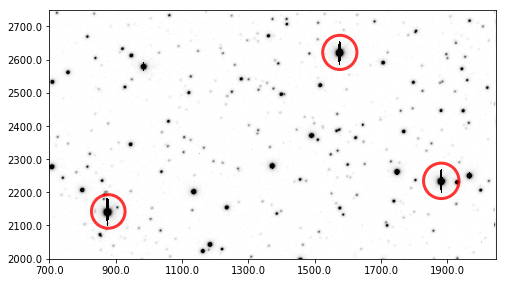

In [80]:
# choose which image to plot...
image_data = lsst_image_data # decam_image_data  # or lsst_image_data

xcords = decam_to_lsst['ccd'+str(ccdnum)+'_x_decaps']
ycords = decam_to_lsst['ccd'+str(ccdnum)+'_y_decaps']

# select a subregion within a chosen part of the image ....
xmin,xmax = 700,xaxis_length # xaxis_length 
ymin,ymax = 2000,2750# yaxis_length 

mx = (xmin < xcords) * (xcords < xmax)
my = (ymin < ycords) * (ycords < ymax)

print('Total sources within this cutout :  %d'%np.sum(mx*my))

# select a subset of the original table within
# this cutout ... ( based on decaps sources in that cutout)
cutout_table = decam_to_lsst[mx*my]

# First select the bright mismatches : only in decam 
# but not in LSST .... 
# (at least not within 0.5 arcsec and 0.5 mag ... )

#xmin,xmax = min(decam_to_lsst[m]['ccd10_x_decaps']), \
#max(decam_to_lsst[m]['ccd10_x_decaps'])
#ymin,ymax = min(decam_to_lsst[m]['ccd10_y_decaps']), \
#max(decam_to_lsst[m]['ccd10_y_decaps'])
# plot the  decam- lsst mismatches .... 
fig,ax = plt.subplots(1,1, figsize=(8,16))

# print the image ....
mean, median, std = sigma_clipped_stats(image_data[ymin:ymax,xmin:xmax],
                                        sigma=3.0, iters=5) 
norm = ImageNormalize(stretch=SqrtStretch())
ax.imshow(image_data[ymin:ymax,xmin:xmax], 
         cmap='Greys', origin='lower', norm=norm,
         vmax = 5000, vmin = 5)


# translate x ticks 
new_labels = [str(item +xmin) for item in ax.get_xticks()]
ax.set_xticklabels(new_labels)

# translate y ticks 
new_labels = [str(item +ymin) for item in ax.get_yticks()]
ax.set_yticklabels(new_labels)

# plot apertures for bright decaps sources, that 
# did not have an lsst match within 0.5 arcsec and 0.5 mag

select_bleeding_sources = False
if select_bleeding_sources : 
    m1 = cutout_table['lsst_match'] == 0
    m2= cutout_table['decaps_mag'] < 11
    m3 = cutout_table['decaps_mag'] > 10
    m4 = cutout_table['lsst_mag'] < 13 
    m = m1*m2*m3*m4
    
if select_

print(cutout_table[m][['decaps_mag', 'lsst_mag','ccd'+str(ccdnum)+'_y_decaps',
                      'ccd'+str(ccdnum)+'_x_decaps',
                      'ccd'+str(ccdnum)+'_y_lsst',
                      'ccd'+str(ccdnum)+'_x_lsst']])
for xx,yy,radius in zip(cutout_table['ccd'+str(ccdnum)+'_x_decaps'][m]-xmin,
                 cutout_table['ccd'+str(ccdnum)+'_y_decaps'][m]-ymin,
                       cutout_table[m]['decaps_mag']*5):
    circ = Circle((xx,yy),radius = radius,
                  alpha=0.8, fill=False, ec = 'red',lw=3)
    ax.add_patch(circ)


# Here we just plot all LSST detections in that region ...   
plot_lsst = False
if plot_lsst : 
    xcords = cutout_table['ccd'+str(ccdnum)+'_x_lsst']
    ycords = cutout_table['ccd'+str(ccdnum)+'_y_lsst']
    for xx,yy in zip(xcords-xmin,ycords-ymin):
        # https://matplotlib.org/devdocs/api/_as_gen/matplotlib.patches.Circle.html 
        circ = Circle((xx,yy), radius=8,alpha=0.8, fill=False, ec='orange')
        ax.add_patch(circ)
    
# Finally, also plot all DECaPS sources in that region 
plot_decaps = False
if plot_decaps : 
    xcords = cutout_table['ccd'+str(ccdnum)+'_x_decaps']
    ycords = cutout_table['ccd'+str(ccdnum)+'_y_decaps']
    for xx,yy in zip(xcords-xmin,ycords-ymin):
        # https://matplotlib.org/devdocs/api/_as_gen/matplotlib.patches.Circle.html 
        circ = Circle((xx,yy), radius=11, alpha=0.8, fill=False, ec='red')
        ax.add_patch(circ)

plt.savefig('../data_products/decaps_lsst_compare/'+str(visit)+\
            '_ccd-'+str(ccdnum)+'_1', bbox_inches='tight')

### Save the illustration code from Decaps_LSST_pipeline to put all illustration data here ... 


#### Show LSST calexp processed image of one CCD <a id='lsst_image'></a>

In [ ]:
# read in the FITS file corresponding to the raw image, 
# and the processed image...

# Read in the LSST Stack processed version
# take just one CCD  ( eg. ccd10)
ccdnum = 10
fname = 'calexp-0'+str(visit)+'_'+str(ccdnum)+'.fits'
print(fname)
hdu = fits.open(outDir + 'calexp/'+fname)
g_zeropoint = hdu[0].header['MAGZERO']

lsst_image_data = hdu[1].data
mean, median, std = sigma_clipped_stats(lsst_image_data, sigma=3.0, iters=5) 
threshold = 5 * std
norm = ImageNormalize(stretch=SqrtStretch())
#fig,ax = plt.subplots(1,1,figsize = (8,16))
#ax.imshow(lsst_image_data, cmap='Greys', origin='lower', norm=norm,
#              vmax = 7000, 
#              vmin = threshold)




#### Show the DECam single-epoch image for the same CCD  <a id='decam_image'></a>

In [ ]:
# Also read the original DECam image 
# and display the same ccd ....

from photutils import CircularAperture

# find the archive image filename

image_name = imdb[imdb['expnum'] == visit]['pldsid'][0]+'.fits.fz'
print('Seeking image %s'%image_name)

image_dir = '../raw_data/DECam/'
if image_name not in os.listdir(image_dir):
    print('Need to download %s'%image_name)
    
# plot the DECam - processed image ... 
image_hdu = fits.open(image_dir +image_name)
#image_hdu[0].header
fwhm = image_hdu[1].header['FWHM'] # Median FWHM in pixels 
print('The median FWHM is %f pixels'%fwhm)

#ccd_name_dict[ccdnum]
#np.ravel(ccd_name_dict)

# position of any ccd in the image_hdu 
# is the ccdnum-1 : 
assert image_hdu[ccdnum-1].header['CCDNUM'] == ccdnum

# select the instcal image data : 
decam_image_data = image_hdu[ccdnum-1].data

print('Min:', np.min(decam_image_data))
print('Max:', np.max(decam_image_data))
print('Mean:', np.mean(decam_image_data))
print('Stdev:', np.std(decam_image_data))


# I fear this works,  but it is just one frame...
mean, median, std = sigma_clipped_stats(decam_image_data, sigma=3.0, iters=5) 

print('Sigma clipped mean: %f'%mean)
print('Sigma clipped median: %f'%median)
print('Sigma clipped stdev: %f'%std)

# set the detection threshold at 5 sigma 
threshold = 5 * std
print('We set the threshold to 5 times the standard deviation \
of pixel value, i.e. %f '%threshold)

norm = ImageNormalize(stretch=SqrtStretch())

fig,ax = plt.subplots(1,1,figsize = (8,16))
ax.imshow(decam_image_data, cmap='Greys', origin='lower', norm=norm,
          vmax = vmax, 
          vmin = f*threshold)
#apertures.plot(color='blue', lw=1.5, alpha=0.5)

### Investigate bright decaps sources without lsst match... 

In [ ]:
ccdnum = 10

# read in the lsst calexp image...
image_name = imdb[imdb['expnum'] == visit]['pldsid'][0]+'.fits.fz'
print('Seeking image %s'%image_name)

image_dir = '../raw_data/DECam/'
if image_name not in os.listdir(image_dir):
    print('Need to download %s'%image_name)
    
# plot the DECam - processed image ... 
image_hdu = fits.open(image_dir +image_name)

In [ ]:
%matplotlib inline
from matplotlib.patches import Circle

# Plot the very bright mismatches .... 

# grab the size of the image in pixels 
# from the image header .... 
xaxis_length = image_hdu[ccdnum-1].header['NAXIS1']
yaxis_length = image_hdu[ccdnum-1].header['NAXIS2']

xcords = decam_to_lsst['ccd10_x_decaps']
ycords = decam_to_lsst['ccd10_y_decaps']

# select a subregion within a chosen part of the image ....
xmin,xmax = 1000,1500 # xaxis_length 
ymin,ymax = 0,500 # yaxis_length 

mx = (xmin < xcords) * (xcords < xmax)
my = (ymin < ycords) * (ycords < ymax)

print('Total sources within this cutout :  %d'%np.sum(mx*my))

# select a subset of the original table within
# this cutout ... ( based on decaps sources in that cutout)
cutout_table = decam_to_lsst[mx*my]

# First select the bright mismatches : only in decam 
# but not in LSST .... 
# (at least not within 0.5 arcsec and 0.5 mag ... )

#xmin,xmax = min(decam_to_lsst[m]['ccd10_x_decaps']), \
#max(decam_to_lsst[m]['ccd10_x_decaps'])
#ymin,ymax = min(decam_to_lsst[m]['ccd10_y_decaps']), \
#max(decam_to_lsst[m]['ccd10_y_decaps'])
# plot the  decam- lsst mismatches .... 
fig,ax = plt.subplots(1,1, figsize=(8,16))

# print the image ....
mean, median, std = sigma_clipped_stats(lsst_image_data[ymin:ymax,xmin:xmax],
                                        sigma=3.0, iters=5) 
norm = ImageNormalize(stretch=SqrtStretch())
ax.imshow(lsst_image_data[ymin:ymax,xmin:xmax], 
         cmap='Greys', origin='lower', norm=norm,
         vmax = 500, vmin = 5)

# plot apertures for bright decaps sources, that 
# did not have an lsst match within 0.5 arcsec and 0.5 mag
m1 = cutout_table['lsst_match'] == 0
m2 = np.bitwise_not(np.isnan(cutout_table['decaps_mag']))
m3 = cutout_table['decaps_mag'] < 16
m = m1*m2*m3
print('Sources with no lsst match, with decaps mag < 13 : %d'%np.sum(m))
print(cutout_table[m][['decaps_mag', 'lsst_mag']])
for xx,yy in zip(cutout_table['ccd10_x_decaps'][m]-xmin,
                 cutout_table['ccd10_y_decaps'][m]-ymin):
    circ = Circle((xx,yy),50, alpha=0.8, fill=False)
    ax.add_patch(circ)

# Here we just plot all LSST detections in that region ...     
xcords = cutout_table['ccd10_x_lsst']
ycords = cutout_table['ccd10_y_lsst']
for xx,yy in zip(xcords-xmin,ycords-ymin):
    # https://matplotlib.org/devdocs/api/_as_gen/matplotlib.patches.Circle.html 
    circ = Circle((xx,yy), radius=8,alpha=0.8, fill=False, ec='orange')
    ax.add_patch(circ)
    
    
# Finally, also plot all DECaPS sources in that region 
xcords = cutout_table['ccd10_x_decaps']
ycords = cutout_table['ccd10_y_decaps']
for xx,yy in zip(xcords-xmin,ycords-ymin):
    # https://matplotlib.org/devdocs/api/_as_gen/matplotlib.patches.Circle.html 
    circ = Circle((xx,yy), radius=11, alpha=0.8, fill=False, ec='red')
    ax.add_patch(circ)

On this image we marged with big black circles the two bright decaps sources that did not have an lsst match within 0.5 arcsec AND 0.5 mag. We overplotted in red all decaps detections, and in orange all lsst detections. We find that indeed there are lsst detections in that location, but the lsst magnitudes are 12.5410783705, 12.5401236168  compared to decaps 11.9704704285   , 11.9622058868, i.e. the difference is bigger than 0.5 mag. We check whether this is the case for all sources brighter than 18 : 

In [ ]:
decam_to_lsst = add_ccd_xycoords(decam_to_lsst, image_hdu, ccdnum=44)
# select 'mismatches' -decaps sources 
# that do not have an lsst source within 0.5 arcsec and 0.5 mag 
m1 = decam_to_lsst['lsst_match'] == 0

# select only bright ones....
m2 = decam_to_lsst['decaps_mag'] < 8

m = m1*m2 
print(decam_to_lsst[m]['decaps_mag','lsst_mag', 'ccd44_x_decaps', 'ccd44_y_decaps'])

Wow, I didn't expect that ! Why would there be super-bright sources that have very faint LSST counterparts? 

In [ ]:
#These are not in ccd10 : go to another..
# It is ccd 44 ! 
ccdnum = 44
fname = 'calexp-0'+str(visit)+'_'+str(ccdnum)+'.fits'
print(fname)
hdu = fits.open(outDir + 'calexp/'+fname)
g_zeropoint = hdu[0].header['MAGZERO']

lsst_image_data = hdu[1].data

In [ ]:
xcords = decam_to_lsst['ccd'+str(ccdnum)+'_x_decaps']
ycords = decam_to_lsst['ccd'+str(ccdnum)+'_y_decaps']

# select a subregion within a chosen part of the image ....
xmin,xmax = 0,xaxis_length # xaxis_length 
ymin,ymax = 0,yaxis_length # yaxis_length 

mx = (xmin < xcords) * (xcords < xmax)
my = (ymin < ycords) * (ycords < ymax)

print('Total sources within this cutout :  %d'%np.sum(mx*my))

# select a subset of the original table within
# this cutout ... ( based on decaps sources in that cutout)
cutout_table = decam_to_lsst[mx*my]

# First select the bright mismatches : only in decam 
# but not in LSST .... 
# (at least not within 0.5 arcsec and 0.5 mag ... )

#xmin,xmax = min(decam_to_lsst[m]['ccd10_x_decaps']), \
#max(decam_to_lsst[m]['ccd10_x_decaps'])
#ymin,ymax = min(decam_to_lsst[m]['ccd10_y_decaps']), \
#max(decam_to_lsst[m]['ccd10_y_decaps'])
# plot the  decam- lsst mismatches .... 
fig,ax = plt.subplots(1,1, figsize=(8,16))

# print the image ....
mean, median, std = sigma_clipped_stats(lsst_image_data[ymin:ymax,xmin:xmax],
                                        sigma=3.0, iters=5) 
norm = ImageNormalize(stretch=SqrtStretch())
ax.imshow(lsst_image_data[ymin:ymax,xmin:xmax], 
         cmap='Greys', origin='lower', norm=norm,
         vmax = 500, vmin = 5)

# plot apertures for bright decaps sources, that 
# did not have an lsst match within 0.5 arcsec and 0.5 mag
m1 = cutout_table['lsst_match'] == 0
m2 = np.bitwise_not(np.isnan(cutout_table['decaps_mag']))
bright_mag = 8
m3 = cutout_table['decaps_mag'] < bright_mag
m = m1*m2*m3
print('Sources with no lsst match, with decaps mag < %d : %d'%(bright_mag,np.sum(m)))
print(cutout_table[m][['decaps_mag', 'lsst_mag','ccd'+str(ccdnum)+'_y_decaps',
                      'ccd'+str(ccdnum)+'_x_decaps',
                      'ccd'+str(ccdnum)+'_y_lsst',
                      'ccd'+str(ccdnum)+'_x_lsst']])
for xx,yy,radius in zip(cutout_table['ccd'+str(ccdnum)+'_x_decaps'][m]-xmin,
                 cutout_table['ccd'+str(ccdnum)+'_y_decaps'][m]-ymin,
                       cutout_table[m]['decaps_mag']*5):
    circ = Circle((xx,yy),radius = radius,
                  alpha=0.8, fill=False, ec = 'red',lw=3)
    ax.add_patch(circ)




# simply plot the magnitudes  : decaps and lsst ....
# I expect that the lsst mags will be smaller than decaps...

plt.scatter(decam_to_lsst[m]['decaps_mag'], 
            decam_to_lsst[m]['lsst_mag'])

In [ ]:
 # translete x ticks to real positions
new_labels = [str(item+xmin) for item in ax.get_xticks()]
ax.set_xticklabels(new_labels)

# translate y ticks to real positions 
new_labels = [str(item+ymin) for item in ax.get_yticks()]
ax.set_yticklabels(new_labels)
    
ax.set_title('mismatches: only in decaps single-epoch ', fontsize=14)
#ax[1.set_title("matches : within 0.5 '' and 0.5 mag ", fontsize=14)
ax.set_ylabel('y arcseconds ', fontsize=15)
#fig.subplots_adjust(wspace=0.1)
ax.tick_params(axis='both', which='major', labelsize=13)
#a#x[1].tick_params(axis='both', which='major', labelsize=13)
#fig.text(0.5,0.1, 'x arcseconds ', fontsize=15)

plt.savefig('../data_products/decaps_lsst_compare/'+str(visit)+'_ccd-'+str(ccdnum)+\
            '_decam_to_lsst_small22.png', bbox_inches='tight', dpi=my_dpi)

## Implement $\Delta m$ vs. $d$ test

We match the catalog to self, and plot the separation as a function of magnitude difference to the nearest neighbor...  ... 

In [117]:
# Let's use decaps coordinates, and decaps magnitudes ....
# compare those objects that have an lsst match, 
# as opposed to those which do not ... 

len(decam_to_lsst)

322654

In [106]:
# select only few cols...
decam  = decam_to_lsst[['decaps_mag','ra','dec', 'dmag', 'lsst_match' ]]w

In [126]:
# match only those decaps sources to self that have LSST match ...
decam_dict = {}
for match in [0,1]:
    m = decam['lsst_match'] == match
    # Match sources from  decaps to lsst  per ccd 
    # decam coordinates
    decam_coord = SkyCoord(ra  = decam['ra'][m]*u.degree, 
                           dec = decam['dec'][m]*u.degree)  
    # indices are into decam  catalog itself
    idx, d2d, d3d = decam_coord.match_to_catalog_sky(decam_coord, nthneighbor=2)  

    # stack the two catalogs 
    decam_self = hstack([decam[m] ,decam[m][idx]],
                   table_names=['one','two']  )

    decam_self['d2d'] = d2d.arcsec
    decam_self['decaps_dmag'] = decam_self['decaps_mag_one'] - decam_self['decaps_mag_two']
    decam_dict[match] = decam_self


/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel/__main__.py:13: RuntimeWarning: invalid value encountered in greater
/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel/__main__.py:13: RuntimeWarning: invalid value encountered in less
/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel/__main__.py:30: RuntimeWarning: divide by zero encountered in log10


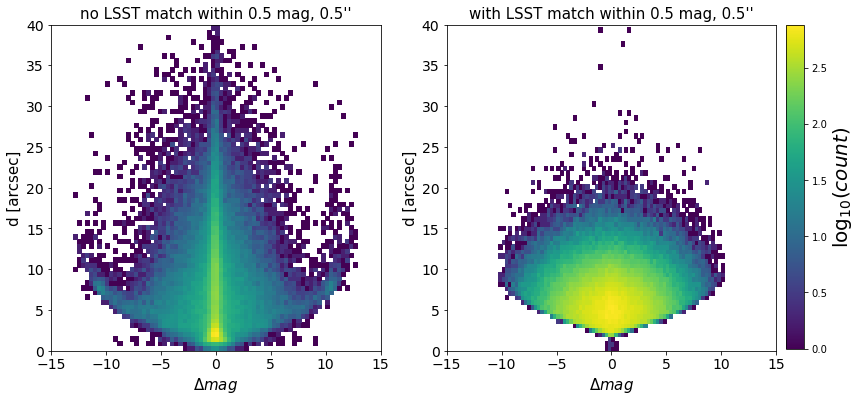

In [182]:
from scipy.stats import binned_statistic_2d

fig,ax = plt.subplots(1,2,figsize=(13,6))
xmin, xmax = -15,15
ymin, ymax = 0,40
colors = {0:'orange', 1:'teal'}
titles = {0:"no LSST match within 0.5 mag, 0.5''", 
          1:"with LSST match within 0.5 mag, 0.5''"}
cm = plt.cm.get_cmap('viridis')
for match in [0,1]:
    x = decam_dict[match]['decaps_dmag']
    y = decam_dict[match]['d2d']
    mx = (xmin < x )*(x < xmax)
    my = (ymin < y) * (y<ymax)
    x = x[mx*my]
    y = y[mx*my]
    
    stats = binned_statistic_2d(x, y, values = x, statistic='count', bins=70)

    z_sigma, x_edges, y_edges = stats[0], stats[1], stats[2]
    # replace all nan's by 0 ...
    z_sigma[np.isnan(z_sigma)] =0 
    z_reduce  =  z_sigma # [:-1, :-1] no need to reduce here because x_edges are already given with the right size 
    z_min, z_max = z_reduce.min(), np.abs(z_reduce).max()
    z_rot = np.rot90(z_reduce)  # rotate and flip to properly display... 
    z_rot_flip = np.flipud(z_rot)
    z_masked = np.ma.masked_where(z_rot_flip == 0 , z_rot_flip)  # mask out zeros... 

    # Plot 2D histogram using pcolor
    image = ax[match].pcolormesh(x_edges,y_edges,np.log10(z_masked), cmap=cm)  
    # np.log10(z_masked) gives log counts 

    #ax[match].scatter(,, s=0.001,
    #          label=str(match), alpha=0.5, color=colors[match])
    #ax[match].legend(loc='upper left', frameon=False,
    #          bbox_to_anchor=(0.71, 0.9), fontsize=15,markerscale=300)
    ax[match].set_xlabel(r'$\Delta mag$', fontsize=15)
    ax[match].set_ylabel('d [arcsec]', fontsize=15)
    ax[match].set_ylim(ymin,ymax)
    ax[match].set_xlim(xmin,xmax)
    ax[match].set_title(titles[match], fontsize=15)
    ax[match].tick_params(axis='both', which='major', labelsize=14)
colorbar_ax = fig.add_axes([0.91, 0.13, 0.02, 0.75])     #  (x0 ,y0  , dx,  dy )  
colorbar = fig.colorbar(image, cax = colorbar_ax,  orientation='vertical')
colorbar.set_label(r'$\log_{10}{(count)}$', fontsize=20)
plt.savefig('../data_products/decaps_lsst_compare/611980/distance_dmag_test.png', 
           bbox_inches='tight')

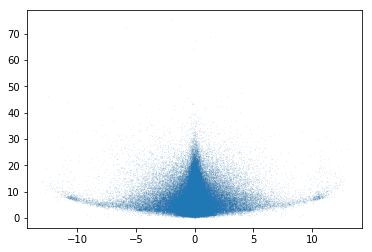

In [125]:
plt.scatter(decam_self['decaps_dmag'], decam_self['d2d'], s=0.001)

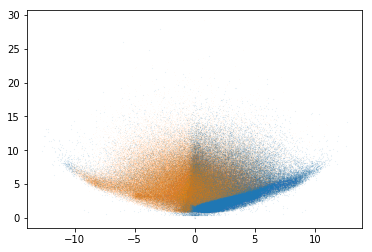

In [116]:
%matplotlib inline
m = decam_self['lsst_match_one'] == 0
plt.scatter(decam_self['decaps_dmag'][m], decam_self['d2d'][m], s=0.001)
m = decam_self['lsst_match_one'] == 1
plt.scatter(decam_self['decaps_dmag'][m], decam_self['d2d'][m], s=0.0001)

In [113]:
m = decam_self['lsst_match_one'] == 0